In [1]:
!pip install gym==0.25.2
import gym
import os
import sys
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
import matplotlib

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class FeatureTransformer:
    def __init__(self, env, n_components=500):
        observation_examples = np.array([env.observation_space.sample() for i in range(10000)])
        scaler = StandardScaler()
        scaler.fit(observation_examples)
        featurizer = FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
            ])
        example_features = featurizer.fit_transform(scaler.transform(observation_examples))
        
        self.dimensions = example_features.shape[0]
        self.scaler = scaler
        self.featurizer = featurizer
    
    def transform(self, observations):
        scaled = self.scaler.transform(observations)
        return self.featurizer.transform(scaled)

In [3]:
class SGDRegressor:
    def __init__(self, **kwargs):
        self.w = None
        self.lr = 0.01
    
    def partial_fit(self, X, Y):
        if self.w is None:
            D = X.shape[1]
            self.w = np.random.randn(D) / np.sqrt(D)
        self.w += self.lr * (Y - X.dot(self.w)).dot(X)
    
    def predict(self, X):
        return X.dot(self.w)

In [10]:
class Model:
    def __init__(self, env, feature_transformer, lr):
        self.env = env
        self.models = []
        self.feature_transformer = feature_transformer
        for i in range(env.action_space.n):
            model = SGDRegressor(learning_rate=lr)
            model.partial_fit(feature_transformer.transform([env.reset()]), [0])
            self.models.append(model)
    
    def predict(self, state):
        X = self.feature_transformer.transform([state])
        result = np.stack([m.predict(X) for m in self.models]).T
        assert(len(result.shape) == 2)
        return result
    
    def update(self, state, action, return_):
        X = self.feature_transformer.transform([state])
        assert(len(X.shape) == 2)
        self.models[action].partial_fit(X, [return_])
        
    def epsilon_greedy(self, state, epsilon):
        if np.random.random() < epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.predict(state))

In [5]:
def plot_cost_to_go(env, estimator, num_tiles=20):
  x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
  y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
  X, Y = np.meshgrid(x, y)
  # both X and Y will be of shape (num_tiles, num_tiles)
  Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))
  # Z will also be of shape (num_tiles, num_tiles)

  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(111, projection='3d')
  surf = ax.plot_surface(X, Y, Z,
    rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
  ax.set_xlabel('Position')
  ax.set_ylabel('Velocity')
  ax.set_zlabel('Cost-To-Go == -V(s)')
  ax.set_title("Cost-To-Go Function")
  fig.colorbar(surf)
  plt.show()

In [6]:
def plot_running_avg(total_rewards):
  number_of_rewards = len(total_rewards)
  running_avg = np.empty(number_of_rewards)
  for t in range(number_of_rewards):
    running_avg[t] = total_rewards[max(0, t-100):(t+1)].mean()
  plt.plot(running_avg)
  plt.title("Running Average")
  plt.show()

In [7]:
DISCOUNT_RATE = 0.9

In [14]:
def play_one_episode(model, epsilon, n=5):
    state = env.reset()
    done = False
    total_reward = 0
    rewards = []
    states = []
    actions = []
    iters = 0
    multiplier = np.array([DISCOUNT_RATE] * int(n)) ** np.arange(n)
    while not done and iters < 10000:
        action = model.epsilon_greedy(state, epsilon)
        states.append(state)
        actions.append(action)
        next_state, reward, done, info = env.step(action)
        rewards.append(reward)
        
        if len(rewards) >= n:
            return_upto_prediction = multiplier.dot(rewards[-n:])
            return_ = return_upto_prediction + (DISCOUNT_RATE ** n) * np.max(model.predict(next_state)[0])
            model.update(states[-n], actions[-n], return_)
        
        total_reward += reward
        iters += 1
        state = next_state
    
    if n == 1:
        states = []
        actions = []
        rewards = []
    else:
        states = states[-n+1:]
        actions = actions[-n+1:]
        rewards = rewards[-n+1:]
    
    if state[0] >= 0.5:
        while len(rewards) > 0:
            return_ = multiplier[:len(rewards)].dot(rewards)
            model.update(states[0], actions[0], return_)
            states.pop(0)
            actions.pop(0)
            rewards.pop(0)
    else:
        while len(rewards) > 0:
            guess_rewards = rewards + [-1] * (n - len(rewards))
            return_ = multiplier.dot(guess_rewards)
            model.update(states[0], actions[0], return_)
            states.pop(0)
            actions.pop(0)
            rewards.pop(0)
            
    return total_reward

/opt/conda/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/opt/conda/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


episode: 100 total reward: -200.0
eps: 0.00023311762989647067
episode: 200 total reward: -200.0
episode: 300 total reward: -200.0
episode: 400 total reward: -200.0
episode: 500 total reward: -200.0
episode: 600 total reward: -200.0
episode: 700 total reward: -200.0
episode: 800 total reward: -200.0
episode: 900 total reward: -200.0
episode: 1000 total reward: -200.0
episode: 1100 total reward: -200.0
episode: 1200 total reward: -175.0
episode: 1300 total reward: -200.0
episode: 1400 total reward: -200.0
episode: 1500 total reward: -200.0
episode: 1600 total reward: -200.0
episode: 1700 total reward: -200.0
episode: 1800 total reward: -169.0
episode: 1900 total reward: -200.0
episode: 2000 total reward: -200.0
episode: 2100 total reward: -200.0
episode: 2200 total reward: -200.0
episode: 2300 total reward: -200.0
episode: 2400 total reward: -200.0
episode: 2500 total reward: -200.0
episode: 2600 total reward: -200.0
episode: 2700 total reward: -200.0
episode: 2800 total reward: -200.0
e

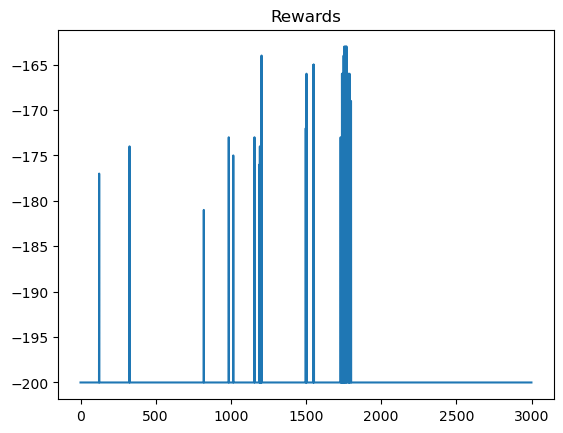

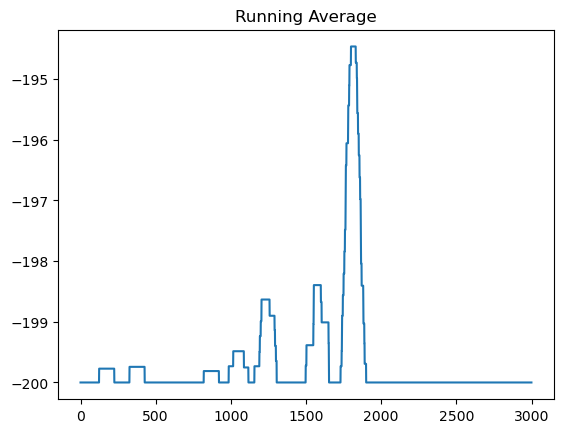

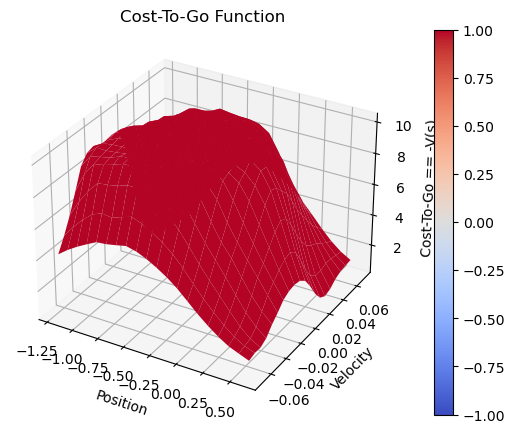

In [16]:
if __name__ == "__main__":
    env = gym.make('MountainCar-v0')
    ft = FeatureTransformer(env)
    model = Model(env, ft, "constant")
 
    number_of_rewards = 3000
    total_rewards = np.empty(number_of_rewards)
    for n in range(number_of_rewards):
        # eps = 1.0/(0.1*n+1)
        eps = 0.1*(0.97**n)
        if n == 199:
            print("eps:", eps)
        # eps = 1.0/np.sqrt(n+1)
        total_reward = play_one_episode(model, eps)
        total_rewards[n] = total_reward
        if (n + 1) % 100 == 0:
            print("episode:", (n + 1), "total reward:", total_reward)
    print("avg reward for last 100 episodes:", total_rewards[-100:].mean())
    print("total steps:", -total_rewards.sum())

    plt.plot(total_rewards)
    plt.title("Rewards")
    plt.show()

    plot_running_avg(total_rewards)

    # plot the optimal state-value function
    plot_cost_to_go(env, model)